Loading Octave text matrix from: scrambled_lena.mat
Initial energy: 165890


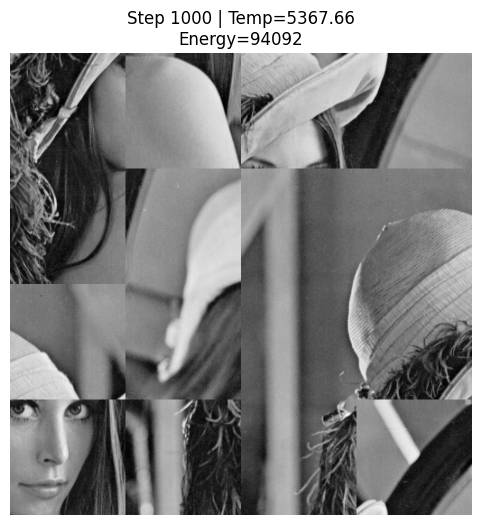

Optimization done. Best energy: 20852


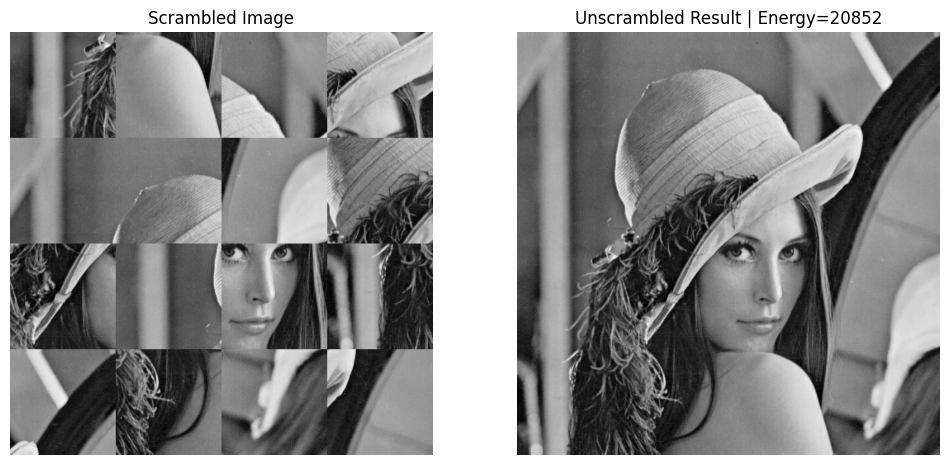

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import time


def load_octave_text_matrix(filename):
    """Load an Octave text-based matrix (like scrambled_lena.mat)"""
    print(f"Loading Octave text matrix from: {filename}")
    with open(filename, 'r') as f:
        lines = f.readlines()

    data_start = 0
    for i, line in enumerate(lines):
        if line.strip().startswith('# ndims:'):
            data_start = i + 2
            break

    if data_start == 0:
        raise ValueError("Header '# ndims:' not found in the file.")

    # Flatten numeric data into a single array
    numeric_data = [line.strip() for line in lines[data_start:]]
    data_flat = np.fromstring(" ".join(numeric_data), dtype=np.uint8, sep=' ')

    img_dim = 512
    if data_flat.size != img_dim * img_dim:
        raise ValueError(f"Data size mismatch! Expected {img_dim**2}, found {data_flat.size}")

    return data_flat.reshape((img_dim, img_dim))


class JigsawSolver:
    """Solves scrambled image blocks using simulated annealing."""

    def __init__(self, scrambled_image, grid=4):
        self.scrambled_image = scrambled_image
        self.grid = grid
        self.blocks, self.block_size = self._split_into_blocks()
        self.num_blocks = len(self.blocks)
        self.perm = list(range(self.num_blocks))

    def _split_into_blocks(self):
        """Split image into equal grid blocks"""
        h, w = self.scrambled_image.shape
        bh, bw = h // self.grid, w // self.grid
        blocks = []

        for i in range(self.grid):
            for j in range(self.grid):
                block = self.scrambled_image[i*bh:(i+1)*bh, j*bw:(j+1)*bw]
                blocks.append(block)

        return blocks, (bh, bw)

    def _calculate_energy(self, perm):
        """Energy = total pixel difference at block borders"""
        total = 0.0
        grid_blocks = [[self.blocks[perm[i*self.grid + j]] for j in range(self.grid)] 
                       for i in range(self.grid)]

        # Horizontal borders
        for i in range(self.grid):
            for j in range(self.grid - 1):
                a, b = grid_blocks[i][j], grid_blocks[i][j + 1]
                total += np.sum(np.abs(a[:, -1].astype(np.int32) - b[:, 0].astype(np.int32)))

        # Vertical borders
        for i in range(self.grid - 1):
            for j in range(self.grid):
                a, b = grid_blocks[i][j], grid_blocks[i + 1][j]
                total += np.sum(np.abs(a[-1, :].astype(np.int32) - b[0, :].astype(np.int32)))

        return float(total)

    def solve(self, initial_temp=5500.0, cooling_rate=0.998,
              iter_per_temp=250, max_steps=50000,
              seed=99, visualize_every=1000):

        np.random.seed(seed)
        random.seed(seed)

        current_energy = self._calculate_energy(self.perm)
        best_perm = self.perm[:]
        best_energy = current_energy

        print(f"Initial energy: {current_energy:.0f}")

        plt.ion()
        fig, ax = plt.subplots(figsize=(6, 6))
        temp = initial_temp
        step = 0

        while step < max_steps and temp > 0.1:
            for _ in range(iter_per_temp):
                if step >= max_steps:
                    break

                a, b = random.sample(range(self.num_blocks), 2)
                self.perm[a], self.perm[b] = self.perm[b], self.perm[a]

                new_energy = self._calculate_energy(self.perm)
                delta = new_energy - current_energy

                # Acceptance probability
                if delta < 0 or (temp > 1e-9 and random.random() < math.exp(-delta / temp)):
                    current_energy = new_energy
                    if current_energy < best_energy:
                        best_energy = current_energy
                        best_perm = self.perm[:]
                else:
                    self.perm[a], self.perm[b] = self.perm[b], self.perm[a]

                step += 1

                if step % visualize_every == 0:
                    self._update_plot(ax, fig, best_perm, step, temp, best_energy)

            temp *= cooling_rate

        plt.ioff()
        print(f"Optimization done. Best energy: {best_energy:.0f}")
        return best_perm, best_energy

    def _update_plot(self, ax, fig, perm, step, temp, energy):
        """Update real-time visualization"""
        ax.clear()
        ax.imshow(self.stitch_image(perm), cmap='gray')
        ax.set_title(f"Step {step} | Temp={temp:.2f}\nEnergy={energy:.0f}")
        ax.axis('off')
        fig.canvas.draw()
        plt.pause(0.001)

    def stitch_image(self, perm):
        """Reconstruct image from permuted blocks"""
        bh, bw = self.block_size
        img = np.zeros((self.grid*bh, self.grid*bw), dtype=self.blocks[0].dtype)
        idx = 0
        for i in range(self.grid):
            for j in range(self.grid):
                img[i*bh:(i+1)*bh, j*bw:(j+1)*bw] = self.blocks[perm[idx]]
                idx += 1
        return img


if __name__ == "__main__":
    try:
        scrambled = load_octave_text_matrix('scrambled_lena.mat').T
        solver = JigsawSolver(scrambled, grid=4)

        best_perm, best_energy = solver.solve(
            initial_temp=5400.0,      # slightly changed temp
            cooling_rate=0.998,       # minor tweak
            iter_per_temp=250,
            max_steps=50000,
            seed=42,                  # different seed
            visualize_every=1000
        )

        final_img = solver.stitch_image(best_perm)

        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(scrambled, cmap='gray')
        plt.title('Scrambled Image')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(final_img, cmap='gray')
        plt.title(f'Unscrambled Result | Energy={best_energy:.0f}')
        plt.axis('off')
        plt.show()

    except Exception as e:
        print(f"Error: {e}")
